In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import cv2, os, math, time
from datetime import timedelta
from sklearn.utils import shuffle
from numpy.lib.stride_tricks import as_strided

### Configuration

In [2]:
###Configuration
"""
Data Configurations/Paths
"""
img_dir="../../original_images/SD"
base_model = 'SD/sd_01_.ckpt'
model_20000 = 'SD/sd_20000.ckpt'
model_30000 = 'SD/sd_30000.ckpt'
model_40000 = 'SD/sd_40000.ckpt'
model_50000 = 'SD/sd_50000.ckpt'

connected_model = 'SD/sd_conected.ckpt'

##
# Convolutional Layer 1.
filter_size1 = 4          # Convolution filters are 4 x 4 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
num_filters2 = 32         # There are 32 of these filters.

# Convolutional Layer 3.
filter_size3 = 2          # Convolution filters are 2 x 2 pixels.
num_filters3 = 64         # There are 64 of these filters.

# Convolutional Layer 4.
filter_size4 = 2          # Convolution filters are 2 x 2 pixels.
num_filters4 = 128         # There are 128 of these filters.

# Fully-connected layer.
fc_size = 2000             # Number of neurons in fully-connected layer.

### Load Data

In [3]:
def change_label_dimensions(labels):
    label_temp = np.zeros((len(labels), 2))
    
    for idx in range(0, len(labels)):
        if labels[idx] == 1:
            label_temp[idx][1] = 1
        else:
            label_temp[idx][0] = 1
    
    return label_temp

def load_data(img_dir):
        list_of_imgs = []
        list_of_labels = []
        for img in os.listdir(img_dir):
            img_path = os.path.join(img_dir, img)
            for img_label in os.listdir(img_path):
                img_data = os.path.join(img_path, img_label)
                if img_label == "img":
#                     print(img_data + "/img.png")
                    list_of_imgs.append(img_data + "/img.png")
                else:
                        list_of_labels.append([os.path.join(img_data, label) for label in os.listdir(img_data)])

        data_imgs = np.array(list_of_imgs)
        data_labels = np.array(list_of_labels)

        return data_imgs, data_labels


# def load_data(img_dir, label):
#         list_of_imgs = []
#         list_of_labels = []
#         for img in os.listdir(img_dir):
#                 img = os.path.join(img_dir, img)
# #                 print(img)
#                 if not img.endswith(".png"):
#                         continue

#                 list_of_imgs.append(img)
#                 list_of_labels.append(label)
#         data_labels = np.asarray(list_of_labels, dtype=np.int32)
#         data_imgs = np.array(list_of_imgs)
# #         data_labels = np.array(list_of_labels)
#         return data_imgs, data_labels
    
def get_batch_images(data, label, rshp):
        list_of_imgs = []
        list_of_labels = []
        for img, lbl in zip(data, label):
            orig_img = cv2.imread(img)
            #only first image as a label
            orig_lbl = cv2.imread(lbl[0])
            if orig_img is None or orig_lbl is None:
                    print ("Unable to read image{} or {}".format(img, lbl))
                    continue
            
            flattened_img = orig_img.flatten()
            flattened_lbl = orig_lbl.flatten()

            list_of_imgs.append(np.asarray(flattened_img, dtype=np.float32))
            list_of_labels.append(np.asarray(flattened_lbl, dtype=np.float32))

        data_labels = np.array(list_of_labels)
        reshaped_labels = np.reshape(data_labels, rshp)
        data_labels = np.squeeze(reshaped_labels[:, :, :1])
#         print(data_labels.shape)
        data_imgs = np.array(list_of_imgs)

        
        return data_imgs, data_labels

### Next Batch Own Implementation

In [4]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

### Data Dimensions

In [5]:
# We know that images are 60 pixels in each dimension.
# img_size = 8 * 4

# Images are stored in one-dimensional arrays of this length.
img_size_flat = 100 * 100

# Number of colour channels for the images: 3 channel for RGB.
num_channels = 3

# Tuple with height and width of images used to reshape arrays.
img_shape = (100, 100, num_channels)


# Number of classes, one class for same or different image
num_classes = 100*100
patch_size = (3, 3)

### Image Plot Functions

In [6]:
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")
        
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(cv2.imread(images[i]).flatten().reshape((8,4, 3)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
    
def generate_size_graph(fig_no, training_size, accuracy, loss, patch_only,patch_conv, start_size, end_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(training_size,accuracy)
    plt.plot(training_size,loss)
    plt.plot(training_size, patch_only)
    plt.plot(training_size, patch_conv)
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title('Training Size vs Accuracy')
    plt.grid(True)
    plt.legend(['SD Original Accuracy','SR Accuracy', 'SD Patch Accuracy', 'SD Patch Conv'])
    plt.style.use(['classic'])
    plt.show()
    plt.savefig(path + '/batch_graphs/' +  str(start_size) + '_' + str(end_size) + '.jpg') 
        
def generate_graph(fig_no, epochs, train, val, label, train_title, val_title, train_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(epochs,train)
    plt.plot(epochs,val)
    plt.xlabel('num of Epochs')
    plt.ylabel(label)
    plt.title(train_title + ' vs ' + val_title + '( Samples:' + str(train_size) + ')')
    plt.grid(True)
    plt.legend(['train','val'])
    plt.style.use(['classic'])
    plt.show()
    plt.savefig(results_path + '/batch_graphs/' +  label + '_' + str(train_size) + '.jpg')     

### Helper Functions for TF Graph Initialization

In [7]:
def new_weights(shape, layer_name):
    initializer = tf.contrib.layers.xavier_initializer()
    return tf.Variable(initializer(shape), name=layer_name+'_W')

def new_bias(length, layer_name):
    return tf.Variable(tf.constant(0.05, shape=[length]), name=layer_name+'_b')

### Helper Functions for Network

In [8]:
def new_conv_layer(input,
                   num_input_channels,
                   filter_size,
                   num_filters,
                   name_scope,
                   layer_name='',
                   use_pooling=True):

    with tf.name_scope(name_scope):
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        weights = new_weights(shape, layer_name)
        biases = new_bias(num_filters, layer_name)

        layer = tf.add(tf.nn.conv2d(input=input, filter=weights, strides=[1,1,1,1], padding='SAME'), biases, name=layer_name)

        if use_pooling:
            layer = tf.nn.max_pool(value=layer,
                                   ksize=[1, 3, 3, 1],
                                   strides=[1, 2, 2, 1],
                                   padding='SAME', name=layer_name+'_max')
        layer = tf.nn.relu(layer, name=layer_name+'_activation')

    return layer, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

def new_fc_layer(input,
                num_inputs,
                num_outputs,
                name_scope,
                layer_name='',
                use_relu=True):
    
    with tf.name_scope(name_scope):
        weights = new_weights([num_inputs, num_outputs], layer_name)
        biases = new_bias(num_outputs, layer_name)

        layer = tf.add(tf.matmul(input, weights),biases,name=layer_name)
    #     layer = tf.matmul(input, weights) + biases

        if use_relu:
            layer = tf.nn.relu(layer, layer_name+'_activation')
    
    return layer

In [9]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat*num_channels], name='x')
x_image = tf.reshape(x, [-1, 100, 100, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
# y_true_cls = tf.argmax(y_true, axis=1)
y_true_cls = tf.placeholder(tf.float32, shape=[None, num_classes * num_channels], name='y_true_cls')
x_image.shape, y_true

(TensorShape([Dimension(None), Dimension(100), Dimension(100), Dimension(3)]),
 <tf.Tensor 'y_true:0' shape=(?, 10000) dtype=float32>)

### Convolution Layers

In [10]:
layer1_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filters1,
                                             name_scope = 'cv',
                                             layer_name='conv1',
                                            use_pooling=True)

layer2_conv2, weights_conv2 =  new_conv_layer(input=layer1_conv1,
                                           num_input_channels=num_filters1,
                                           filter_size=filter_size2,
                                           num_filters=num_filters2,
                                             name_scope = 'cv',
                                             layer_name='conv2',
                                           use_pooling=True)

layer3_conv3, weights_conv3 =  new_conv_layer(input=layer2_conv2,
                                           num_input_channels=num_filters2,
                                           filter_size=filter_size3,
                                           num_filters=num_filters3,
                                             name_scope = 'cv',
                                             layer_name='conv3',
                                           use_pooling=True)

layer4_conv4, weights_conv4 =  new_conv_layer(input=layer3_conv3,
                                           num_input_channels=num_filters3,
                                           filter_size=filter_size4,
                                           num_filters=num_filters4,
                                             name_scope = 'cv',
                                             layer_name='conv4',
                                           use_pooling=True)

In [11]:
layer_flat, num_features = flatten_layer(layer4_conv4)

### Fully Connected Layers

In [12]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size+2,
                         name_scope = 'fc',
                         layer_name = 'fc1',
                         use_relu=True)


layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size+2,
                         num_outputs=fc_size+4,
                         name_scope = 'fc',
                         layer_name = 'fc2',
                         use_relu=False)

layer_fc3 = new_fc_layer(input=layer_fc2,
                         num_inputs=fc_size+4,
                         num_outputs=num_classes,
                         name_scope = 'fc',
                         layer_name = 'fc3',
                         use_relu=False)

layer_fc4 = new_fc_layer(input=layer_fc3,
                         num_inputs=num_classes,
                         num_outputs=num_classes,
                         name_scope = 'fc',
                         layer_name = 'fc4',
                         use_relu=False)

y_pred_cls = layer_fc4
y_pred = layer_fc4

### Cost Function

In [13]:
cost = tf.reduce_mean(tf.square(y_true - y_pred_cls))

### Optimization Method

In [14]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## some more performance measures
correct_prediction = tf.equal(y_pred_cls, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Run Tensorflow on Defined Graph

In [15]:
session = tf.Session()
session.run(tf.global_variables_initializer())
train_data, train_labels = load_data(img_dir)
train_batch_size = 64

def optimize(num_iterations, save_model=True,save_name=base_model,restore_model=False,restore_name=None):
    total_iterations = 0
    done_train_imgs = 0
    start_time = time.time()
    start_batch=0
    end_batch = train_batch_size
    plot_accuracy=[]
    plot_training_size=[]
    
    #to save the model
    saver = tf.train.Saver()

    if restore_model==True:
        if restore_name==None:
            print("No model file specified")
            return
        else:
            saver.restore(session,restore_name)
            
    
    for i in range(0, num_iterations):
        total_iterations = 0
        start_batch=0
        end_batch = train_batch_size
#         train_data, train_labels = load_data(img_dir)
        while total_iterations < 30:
            train = train_data[start_batch:end_batch]
            labels = train_labels[start_batch:end_batch]
            dims = (train_batch_size, num_classes, num_channels)
            train, labels = get_batch_images(train, labels, dims)
            if not len(train) and not len(labels):
                print("All images have been processed.")
                break;

            x_batch, y_true_batch = next_batch(train_batch_size, train, labels)
    #         x_batch, y_true_batch = train_data[done_train_images:done_train_imgs+train_batch_size]
            feed_dict_train = {x: x_batch,
                       y_true: y_true_batch}
            
            session.run(optimizer, feed_dict=feed_dict_train)

    #         if total_iterations%1000==0:    
            acc,co = session.run([accuracy, cost], feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Loss: {2:>.4f}"
            print(msg.format(total_iterations + 1, acc, co))
            
            plot_accuracy.append(acc)
            plot_training_size.append((total_iterations + 1) * 64)

                # Update the total number of iterations performed.
    #         done_train_imgs+=train_batch_size
            start_batch += train_batch_size
            end_batch += train_batch_size
            total_iterations +=1

        if save_model==True:
            if save_name==None:
                print("No model specified, model not being saved")
                return
            else:
                save_path = saver.save(session, save_name)
                print("Model saved in file: %s" % save_name)
        
#         total_iterations += num_iterations

    # Ending time.
    end_time = time.time()
    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))  
    print(plot_accuracy)
    print(plot_training_size)

### Performance/Optimization

In [16]:
save_model = True
save_name = model_50000
restore_model=False
restore_name=model_50000

optimize(num_iterations=1000, save_model=True,save_name=model_50000,restore_model=False,restore_name=model_50000)

Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 240.0395
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 237.1918
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 236.3749
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 235.1884
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 233.9779
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 233.8479
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 233.2229
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 233.1349
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 232.4705
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 232.2793
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 231.9700
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 231.7820
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 231.6535
Optimization Iteration:     14, Traini

Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 209.6355
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 209.4322
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 210.9084
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 208.5415
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 208.5923
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 208.7719
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 208.4593
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 208.4539
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 206.3833
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 207.5594
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 205.7242
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 204.4318
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 205.2582


Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 174.0445
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 171.6736
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 173.0729
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 172.4232
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 170.0826
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 171.5222
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 169.7141
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 173.1454
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 172.2597
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 169.5719
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 168.3588
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 169.7345
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 169.2201
Optimization Iteration:     23, Traini

Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 147.0145
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 146.9135
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 144.8552
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 146.0503
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 144.6510
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 147.1499
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 147.1495
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 148.8390
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 146.0623
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 144.9669
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 146.2643
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 143.7065
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 145.2108


Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 125.6663
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 125.1612
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 125.9685
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 125.3200
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 129.9196
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 124.6404
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 124.8813
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 126.2805
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 122.6866
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 123.6805
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 121.3826
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 124.2802
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 123.6728


Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 108.2692
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 107.3883
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 109.4326
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 107.3944
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 107.8384
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 107.1861
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 103.9313
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 107.4715
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 104.9876
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 110.0470
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 109.3868
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 107.1442
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 106.3541
Optimization Iteration:     21, Traini

Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 93.4581
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 91.5977
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 93.6840
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 94.0643
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 92.4764
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 91.3740
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 91.9594
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 94.1240
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 92.3477
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 96.7607
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 92.7899
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 92.4910
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 93.6870
Optimization 

Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 83.5630
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 83.3576
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 83.4972
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 83.7597
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 85.7796
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 83.5838
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 82.7047
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 84.6778
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 81.1033
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 81.8848
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 80.0012
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 82.4697
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 82.1291
Optimization 

Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 74.4162
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 74.4030
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 73.0093
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 71.5620
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 68.8654
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 72.2301
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 71.6458
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 74.3499
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 74.8628
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 74.0046
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 74.2713
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 74.1826
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 73.7789
Optimization Iteration:     23, Training Accuracy: 

Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 67.3629
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 66.4746
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 64.3321
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 65.5912
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 65.9552
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 64.6410
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 68.7161
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 65.7833
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 65.7722
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 66.3562
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 66.6636
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 65.5247
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 63.8298
Optimization 

Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 60.7607
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 63.1079
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 61.2574
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 60.4280
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 62.6720
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 59.7778
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 60.0536
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 59.0188
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 60.6243
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 61.0038
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 59.9742
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 58.2133
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 59.5019
Optimization 

Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 52.9744
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 51.8300
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 53.9134
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 54.3023
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 56.3269
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 56.2685
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 55.3848
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 55.5396
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 56.2011
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 54.6881
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 56.6922
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 55.5233
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 54.7743
Optimization Iteration:     26, Training Accuracy: 

Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 50.1221
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 50.5745
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 49.2231
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 52.9355
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 50.4950
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 50.5335
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 50.5642
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 51.0817
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 50.0348
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 48.2480
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 47.5857
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 48.9046
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 49.7236
Optimization Iteration:     17, Training Accuracy: 

Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 47.1311
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 48.2301
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 46.3796
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 47.2519
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 46.8640
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 47.7828
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 47.3853
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 47.2326
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 45.5410
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 46.9559
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 46.9795
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 45.3954
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 48.4961
Optimization 

Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 43.4712
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 44.6470
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 44.1679
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 43.9967
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 44.4649
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 44.5266
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 43.0172
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 44.5385
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 43.8359
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 43.7987
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 44.3672
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 42.7599
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 43.4153
Optimization Iteration:     29, Training Accuracy: 

Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 42.9747
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 40.8018
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 40.9937
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 41.4068
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 41.6914
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 40.4393
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 38.6719
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 38.3448
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 39.5900
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 40.1959
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 41.3374
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 40.7738
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 40.5247
Optimization Iteration:     20, Training Accuracy: 

Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 38.3323
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 38.1240
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 38.6411
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 38.7421
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 38.2961
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 37.2047
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 38.7430
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 38.9542
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 37.6183
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 40.5477
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 38.7173
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 38.8114
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 38.8902
Optimization 

Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 36.6297
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 36.7260
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 36.7930
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 35.2357
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 36.3410
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 36.3037
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 35.8362
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 36.5180
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 35.0415
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 35.8087
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 35.8142
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 36.1465
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 35.9291
Optimization 

Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 33.8980
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 34.8395
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 33.9887
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 32.0797
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 31.7329
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 33.0369
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 33.5378
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 34.8281
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 33.9087
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 33.7186
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 34.2074
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 33.7523
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 33.4733
Optimization Iteration:     23, Training Accuracy: 

Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 32.1235
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 32.6981
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 31.7531
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 32.7072
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 32.4109
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 31.4453
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 34.0378
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 32.6844
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 32.4072
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 32.5263
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 33.1032
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 32.6353
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 30.8773
Optimization 

Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 30.6585
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 30.9228
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 31.0082
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 30.8714
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 31.1023
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 30.0024
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 30.6416
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 30.6517
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 30.8778
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 30.5406
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 31.0716
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 29.8813
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 30.9117
Optimization 

Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 28.3428
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 27.8186
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 28.8720
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 29.7121
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 30.3053
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 29.7029
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 29.8272
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 30.6011
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 30.3240
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 29.7266
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 30.0419
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 29.8939
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 29.5854
Optimization Iteration:     26, Training Accuracy: 

Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 28.6861
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 28.8122
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 27.6320
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 29.9988
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 28.6975
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 28.4468
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 28.2543
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 29.2846
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 28.7487
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 27.0887
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 26.4401
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 27.4099
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 28.3580
Optimization Iteration:     17, Training Accuracy: 

Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 27.0691
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 27.2947
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 26.3905
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 26.7849
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 26.8473
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 27.2798
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 27.2600
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 27.2899
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 26.6161
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 26.9473
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 26.9321
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 26.1390
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 28.2982
Optimization 

Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 26.1215
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 26.5562
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 25.9133
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 25.8827
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 26.4475
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 26.0827
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 25.8013
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 26.2104
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 26.2813
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 25.9801
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 26.4824
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 25.7125
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 25.8707
Optimization Iteration:     29, Training Accuracy: 

Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 26.5210
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 25.3808
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 25.3768
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 25.0146
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 26.1392
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 25.7930
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 24.3271
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 23.8272
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 24.4791
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 25.1210
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 25.4572
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 25.2245
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 25.5382
Optimization Iteration:     20, Training Accuracy: 

Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 24.3505
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 24.4560
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 24.5154
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 24.2777
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 24.5002
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 24.2233
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 24.3672
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 24.3134
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 23.5431
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 25.5854
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 24.3719
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 24.2989
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 24.0234
Optimization 

Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 23.2285
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 23.8112
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 23.6054
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 23.2185
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 23.2244
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 23.3355
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 23.1014
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 23.4357
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 22.8103
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 23.0374
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 22.9559
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 23.2716
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 23.2693
Optimization 

Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 22.4856
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 23.5034
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 22.9626
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 21.5673
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 20.8845
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 21.8931
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 22.8118
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 23.1649
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 22.6401
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 22.2703
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 22.9600
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 22.3170
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 22.1831
Optimization Iteration:     23, Training Accuracy: 

Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 21.3998
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 21.6563
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 21.1661
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 21.6738
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 21.8270
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 20.8239
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 22.6351
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 21.5798
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 21.7235
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 21.3009
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 22.1362
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 21.8566
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 20.6477
Optimization 

Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 21.3616
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 21.2899
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 21.6989
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 21.4275
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 21.6540
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 21.0703
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 21.0841
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 21.3459
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 21.4260
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 20.9050
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 20.7858
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 20.4653
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 20.7190
Optimization 

Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 19.6548
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 19.2978
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 19.9881
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 20.7253
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 20.9587
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 20.6528
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 20.4276
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 20.9624
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 20.6646
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 20.5682
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 20.4614
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 20.6755
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 20.6519
Optimization Iteration:     26, Training Accuracy: 

Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 20.0802
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 20.1631
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 19.5035
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 21.0312
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 19.9395
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 20.1331
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 19.7638
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 20.4949
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 20.1441
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 18.8703
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 18.5779
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 19.2018
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 20.1486
Optimization Iteration:     17, Training Accuracy: 

Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 19.8089
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 19.8600
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 19.4089
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 19.3983
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 19.6113
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 19.9198
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 19.4705
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 19.6937
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 19.4732
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 20.0020
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 20.1061
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 19.4220
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 20.6052
Optimization 

Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 19.2172
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 19.6065
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 19.3636
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 19.0938
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 19.9527
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 19.6656
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 19.3332
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 18.9707
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 19.3599
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 19.2965
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 19.5132
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 18.4983
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 19.0005
Optimization Iteration:     29, Training Accuracy: 

Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 19.4809
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 18.8696
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 19.0766
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 18.7583
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 19.5157
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 19.2529
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 18.1830
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 17.7231
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 18.2951
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 19.1422
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 19.1618
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 18.8690
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 18.2402
Optimization Iteration:     20, Training Accuracy: 

Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 18.0405
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 18.5841
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 18.7468
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 18.2482
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 18.2733
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 18.1678
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 18.2485
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 18.2918
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 17.7086
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 18.9267
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 18.3797
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 18.3409
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 18.0637
Optimization 

Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 18.2839
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 18.4662
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 18.1739
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 18.0998
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 17.9116
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 18.1679
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 17.7478
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 18.0058
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 17.5360
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 17.6915
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 17.7169
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 18.0454
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 17.8710
Optimization 

Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 17.4898
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 18.0590
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 17.9701
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 17.3149
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 16.6318
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 17.1407
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 17.8124
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 18.0127
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 17.8409
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 17.7158
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 18.2456
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 17.7709
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 17.8287
Optimization Iteration:     23, Training Accuracy: 

Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 16.9070
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 16.9400
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 16.8486
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 16.9011
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 16.8453
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 16.5219
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 17.6402
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 16.9467
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 16.9469
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 16.5932
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 17.3225
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 17.2394
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 16.1766
Optimization 

Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 16.4293
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 16.2754
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 16.6786
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 16.5243
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 16.6602
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 16.1047
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 16.2664
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 16.4765
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 16.6188
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 16.2131
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 16.3720
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 16.2600
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 16.3740
Optimization 

Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 15.6536
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 15.2651
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 15.6131
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 16.1293
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 16.3708
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 16.2418
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 15.7996
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 16.5350
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 16.2393
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 16.0037
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 15.8196
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 16.1613
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 15.9601
Optimization Iteration:     26, Training Accuracy: 

Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 15.6909
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 15.8446
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 15.2908
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 16.0726
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 15.5285
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 15.6518
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 15.5485
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 15.8760
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 15.9889
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 15.2417
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 14.9717
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 15.2865
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 15.6450
Optimization Iteration:     17, Training Accuracy: 

Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 15.4472
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 15.6147
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 15.2730
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 15.4269
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 15.4514
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 15.6627
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 15.3883
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 15.2898
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 15.3180
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 15.5490
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 15.4619
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 15.0652
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 15.8833
Optimization 

Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 15.0967
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 15.4436
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 15.4214
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 15.2279
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 15.8709
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 15.3170
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 15.2564
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 15.1344
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 15.3403
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 15.1227
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 15.4426
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 14.9616
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 15.0073
Optimization Iteration:     29, Training Accuracy: 

KeyboardInterrupt: 

In [ ]:
def normalise(tensor):
    return tf.div(
   tf.subtract(
      tensor, 
      tf.reduce_min(tensor)
   ), 
   tf.subtract(
      tf.reduce_max(tensor), 
      tf.reduce_min(tensor)
   )
)

In [17]:
def restore_see_layer(ix, model_name=None, var_name=None):
    with tf.Session('', tf.Graph()) as s:
        with s.graph.as_default():
            if ((model_name != None) and var_name != None):
                saver = tf.train.import_meta_graph(model_name+".meta")
                saver.restore(s, model_name)
                fd = {'x:0':ix}
                var_name=var_name+":0"
                    
                result = 0
                result = s.run(var_name, feed_dict=fd)
    return result

In [18]:
train_data, train_labels = load_data(img_dir)
batch_s = 64
train = train_data[0:batch_s]
labels = train_labels[0:batch_s]
dims = (batch_s, num_classes, num_channels)
train, labels = get_batch_images(train, labels, dims)

In [19]:
np.set_printoptions(suppress=True)

img_x = train[0:1, :]#np.expand_dims(train[0], axis=0).shape
lbl_x = labels[0:1, :]

# reshaped_lbl = np.reshape(lbl_x, (1, 4, 4, 3))
# reshaped_img = np.reshape(img_x, (1, 4, 4, 3))
# new_lbl = np.squeeze(reshaped_lbl[:, :, :, :1])
output_cl1 = restore_see_layer(ix=img_x,model_name=model_50000,var_name='fc_3/fc4')
output_fc4_w = restore_see_layer(ix=img_x,model_name=model_50000,var_name='fc_3/fc4_W')

# output_cl1 = np.squeeze(np.reshape(output_cl1, (1, 10, 10, 1)))

print(output_cl1.shape)
print(output_cl1)
print(lbl_x)
print(output_fc4_w.shape)
# print(lbl_x.shape)

INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
(1, 10000)
[[ 4.6186557  10.776645    9.468608   ... -0.56341887 -0.80322796
  -0.29804966]]
[[0. 0. 0. ... 0. 0. 0.]]
(10000, 10000)


In [20]:
# print(output_cl1.shape)
# print(output_fc4_w.shape)

# sess2 = tf.Session()
# sess2.run(tf.global_variables_initializer())
# logits = tf.matmul(output_cl1, output_fc4_w)
print(output_cl1)
# print(logits.eval(session=sess2))
# print(tf.nn.softmax(logits).eval(session=sess2))
print(lbl_x)
# print(np.reshape(lbl_x, (10, 10)))

[[ 4.6186557  10.776645    9.468608   ... -0.56341887 -0.80322796
  -0.29804966]]
[[0. 0. 0. ... 0. 0. 0.]]


In [21]:
# np.set_printoptions(suppress=True)
# # print('original image:', original_image)
# # print(np.array(output_cl1, dtype=np.int64))

# # print(output_cl1)


predicted_output = output_cl1
output_cl1[np.where(output_cl1 < 100)] = 0.
output_cl1[np.where(output_cl1 > 100)] = 1.

print(predicted_output)
print(lbl_x)
print(np.where(predicted_output == 1))
print(np.where(lbl_x == 255))
# print(output_fc4_w)

[[0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]]
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([ 440,  441,  442,  540,  541,  542,  640,  641,  642, 1135, 1136,
       1137, 1235, 1236, 1237, 1335, 1336, 1337, 4153, 4154, 4155, 4253,
       4254, 4255, 4353, 4354, 4355, 5241, 5242, 5243, 5341, 5342, 5343,
       5441, 5442, 5443]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([ 440,  441,  442,  540,  541,  542,  640,  641,  642, 1135, 1136,
       1137, 1235, 1236, 1237, 1335, 1336, 1337, 4153, 4154, 4155, 4253,
       4254, 4255, 4353, 4354, 4355, 5241, 5242, 5243, 5341, 5342, 5343,
       5441, 5442, 5443]))


In [22]:
np_m = np.squeeze(np.reshape(predicted_output, (1,100, 100,1)))
np_m

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [23]:
r = img_shape[0]
c = img_shape[1]
rp = patch_size[0]
cp = patch_size[1]
conv_r= r - rp + 1
conv_c = c - cp + 1

all_ones = np.ones((conv_r,conv_c))
for i in range(0, rp):
    for j in range(0, cp):
#         print(np_m[0+i:conv_r+i, 0+j:conv_c+j])
        all_ones = np.multiply(all_ones, np_m[0+i:conv_r+i, 0+j:conv_c+j])

print(all_ones)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [24]:
res = all_ones

In [25]:
patch_size

(3, 3)

In [29]:
reshaped_img = np.reshape(img_x, (1, 100, 100, 3))
x, y = np.where(res == 1)

x,y

reshaped_img1 = reshaped_img[:, x[0]:x[0] + patch_size[0], y[0]:y[0]+patch_size[1], :]
reshaped_img2 = reshaped_img[:, x[1]:x[1] + patch_size[0], y[1]:y[1]+patch_size[1], :]
reshaped_img3 = reshaped_img[:, x[2]:x[2] + patch_size[0], y[2]:y[2]+patch_size[1], :]
reshaped_img4 = reshaped_img[:, x[3]:x[3] + patch_size[0], y[3]:y[3]+patch_size[1], :]


# print(np.reshape(img_x, (1, 10, 10, 3)))
# print(reshaped_img.shape)

In [ ]:
sess2 = tf.Session()
patch_size = 4
m = predicted_output

# kernel = tf.constant(1, shape=(patch_size,), dtype=tf.float32)

# data   = tf.reshape(i, [1, int(i.shape[1]), 1], name='data')
# kernel = tf.reshape(kernel, [int(kernel.shape[0]), 1, 1], name='kernel')

# res = tf.squeeze(tf.nn.conv1d(data, kernel, 1, 'SAME'))


# k = tf.ones([patch_size], dtype=tf.float32, name='k')
# beta = tf.Variable(tf.random_normal([10,10], dtype=tf.float32, seed=2))

mask = tf.Variable(m, dtype=tf.float32, name='mask')
k = tf.ones([patch_size], dtype=tf.float32, name='k')

sess2.run(tf.global_variables_initializer())
print(mask.eval(session=sess2))
paddings = tf.constant([[0, patch_size-1]])
padded_mask = tf.pad(tf.squeeze(mask), paddings, "CONSTANT")
print(padded_mask.get_shape())
print(padded_mask.eval(session=sess2))
padded_mask   = tf.reshape(padded_mask, [1, int(padded_mask.shape[0]), 1], name='padded_mask')
kernel = tf.reshape(k, [int(k.shape[0]), 1, 1], name='kernel')

res = tf.squeeze(tf.nn.conv1d(padded_mask, kernel, 1, 'VALID'))
print(res.get_shape())
print(res.eval(session=sess2))


# logits = tf.matmul(tf.expand_dims(res, 0), output_fc4_w)
softmax_logis = tf.nn.softmax(tf.expand_dims(res, 0))

weights = tf.squeeze(tf.cast(tf.where(
        tf.equal(tf.reduce_max(softmax_logis, axis=1, keepdims=True), softmax_logis), 
        tf.constant(1, shape=softmax_logis.shape), 
        tf.constant(0, shape=softmax_logis.shape)
    ), dtype=tf.float32))

print(weights.get_shape())
print(weights.eval(session=sess2))

# weights_var = tf.Variable(weights, name="weights_var")
# indices = tf.squeeze(tf.where(tf.greater(weights, 0)))
# sess2.run(tf.global_variables_initializer())

# valuesofindices = np.delete(indices.eval(session=sess2),
#                             0)

# updated_weights = tf.scatter_update(weights_var,
#                            valuesofindices,
#                            tf.tile(tf.constant([0],
#                                    tf.float32),
#                            valuesofindices.shape))

# print(updated_weights.eval(session=sess2))

end_range = 25
img_x_t = tf.convert_to_tensor(np.squeeze(np.array(img_x)))
xm = tf.map_fn(lambda i: img_x_t[i:i+end_range], tf.range(patch_size), dtype=tf.float32)
patch = tf.reduce_sum(tf.matmul(xm, tf.expand_dims(weights[0:end_range], 1)), axis=1)
print(img_x_t.eval(session=sess2))
patch.eval(session=sess2)

In [30]:
def see_output(iNp,depth_filter_to_see=0,cmap="gray",figsize=(4,4)):
    img_x = iNp[0,:,:,:]
    fig = plt.figure(figsize=figsize)
    plt.imshow(img_x, interpolation='none', aspect='auto')
#     plt.colorbar(img_x, orientation='horizontal')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


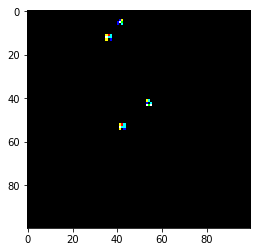

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


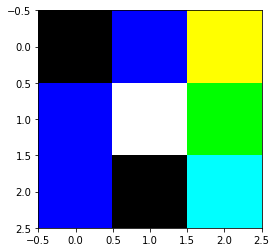

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


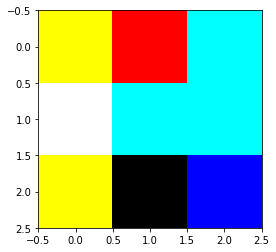

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


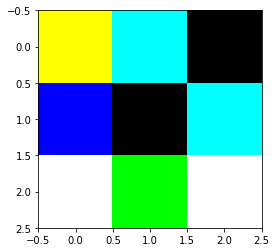

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


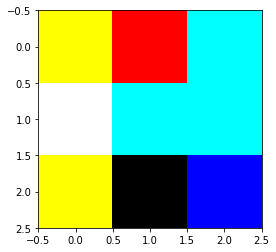

In [31]:
original_image = np.reshape(img_x, (1, 100, 100, 3))
# predicted_image = np.reshape(output_cl1, (1, 4, 4, 3))
# visual_image = np.reshape(patch.eval(session=sess2), (1, 2, 4, 3))
# visual_label = np.reshape(lbl_x, (1, 4, 4, 3))

# visual_image_conn = np.reshape(output_fully_connected, (1, 120, 120, 3))
# visual_label_conn = np.reshape(lbl_x, (1, 120, 120, 3))
see_output(original_image)
# see_output(visual_label)
# see_output(predicted_image)
# see_output(visual_image)
# reshaped_img = reshaped_img[:, x[0]:x[0] + 2, y[0]:y[0]+2, :]
see_output(reshaped_img1)
see_output(reshaped_img2)
see_output(reshaped_img3)
see_output(reshaped_img4)